# Deep Learning &mdash; Assignment 10

Tenth assignment for the 2024 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names:** Andrew Schroeder and Fynn Gerding

**Group:** 17

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers concise and to the point, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Implement the components of a normalizing flow model.
2. Train a normalizing flow on a simple dataset.
3. Compare normalizing flows to other models.

## Required software

As before you will need these libraries:
* `torch`
* `sklearn`

All libraries can be installed with `pip install`.

In [1]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline

import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions.distribution
from torch.distributions import Distribution, Normal, MultivariateNormal
import sklearn.datasets

# Fix the seed to make the solutions more reproducible
torch.manual_seed(12345);

# Use the GPU if available
def detect_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")
device = detect_device()

## 10.1 Invertible transformations (5 points)

A normalizing flow model is built out of invertible functions. We can implement these as a module that not only has a `forward` function, but also an `inverse`.

In addition to computing the function $z = f(x)$, we will also need to know the (log) determinant of the Jacobian, that is $\det(\partial f(z) / \partial z)$. While we could use automatic differentiation to compute the Jacobian, that is very expensive, and we would then still need to compute the determinant, and we also need gradients of this log determinant. So instead, we will make our layers return a tuple of the new value and the log determinant.
We will have a closer look at what this means in the next section.

In [2]:
class FlowLayer(torch.nn.Module):
    def forward(self, z):
        """
        Apply a transformation to z_1, and compute log determinant of the Jacobian.
        z can be a tensor or a tuple of tensors.
        Return z_2, log det(∂z_2/∂z_1)
        """
        raise NotImplementedError("Forward function not implemented")

    def inverse(self, z):
        """
        Transformation that is the inverse of self.forward()
        Return z_1, log det(∂z_1/∂z_2)
        """
        raise NotImplementedError("Inverse function not implemented")

A nice aspect of these FlowLayers is that we can test if they are implemented correctly by checking that `layer.inverse(layer.forward(x)[0])[0] == x`.
Below is a function that tests that a flow layer is implemented correctly by checking this and other properties.
You do not have to understand all the details.

In [3]:
def isclose(a,b):
    """
    Returns True if two tensors or tuples of tensors are equal or close to equal.
    """
    if isinstance(a, tuple):
        return len(a) == len(b) and all([isclose(c,d) for c,d in zip(a,b)])
    elif isinstance(a, int) or isinstance(a, float):
        return isclose(torch.tensor(a), torch.tensor(b))
    else:
        return torch.isclose(a, b, atol=1e-6).all()

def num_samples(a):
    """
    Return the number of samples in a tensor or in a tuple of tensors.
    """
    if isinstance(a, tuple):
        return num_samples(a[0])
    else:
        return len(a)

def log_det_jacobian(layer, a, *args):
    """
    Compute logdet of the Jacobian using automatic differentiation.
    """
    if isinstance(a, tuple):
        j = torch.autograd.functional.jacobian(lambda *a: layer.forward(a, *args)[0], a)
    else:
        j = torch.autograd.functional.jacobian(lambda a: layer.forward(a, *args)[0], a)
    out = torch.zeros(num_samples(a))
    for i in range(num_samples(a)):
        if isinstance(j, torch.Tensor):
            ji = j[i,:,i,:]
        elif isinstance(j[0], torch.Tensor):
            if isinstance(a, tuple):
                ji = torch.cat([r[i,:,i,:] for r in j], dim=1)
            else:
                ji = torch.cat([r[i,:,i,:] for r in j], dim=0)
        else:
            ji = torch.cat([torch.cat([c[i,:,i,:] for c in r], dim=1) for r in j], dim=0)
        out[i] = torch.logdet(ji)
    return out

def scalar_to_vector(x, n):
    if not isinstance(x, torch.Tensor):
        return torch.tensor(x, dtype=torch.float).repeat(n)
    elif x.shape == torch.Size():
        return x.repeat(n)
    else:
        return x

def test_flow_layer(layer, z, *args):
    """
    Verify that a layer's forward() and inverse() functions are inverses of each other,
    and that the log determinant is sensible.
    """
    z2, log_det_forward = layer.forward(z, *args)
    z3, log_det_inverse = layer.inverse(z2, *args)
    log_det_forward = scalar_to_vector(log_det_forward, num_samples(z))
    log_det_inverse = scalar_to_vector(log_det_inverse, num_samples(z))
    assert num_samples(z2) == num_samples(z), \
            "Layer's output should have same number of samples as the input."
    assert isclose(z3, z), \
            "Layer's `inverse` function should be the inverse of `forward`."
    assert isinstance(log_det_forward, torch.Tensor) and log_det_forward.shape == torch.Size([num_samples(z)]), \
            "Log determinant of Jacobian should be a tensor with one element per sample (hint: `num_samples` gives the number of samples)."
    assert isclose(log_det_forward, -log_det_inverse), \
            "Log determinant of Jacobian for inverse should be negative of log determinant of Jacobian of forward."
    assert isclose(log_det_forward, log_det_jacobian(layer, z, *args)), \
            "Log determinant returned by `forward` should match that computed using `log_det_jacobian`"

### How transformations affects probability density

Suppose that we have $z \sim U(0,1)^2$, that is, $z$ has a two dimensional uniform distribution.
Now scale the values by a factor $2$, $z_2 = 2z$.

torch.Size([1000, 2])


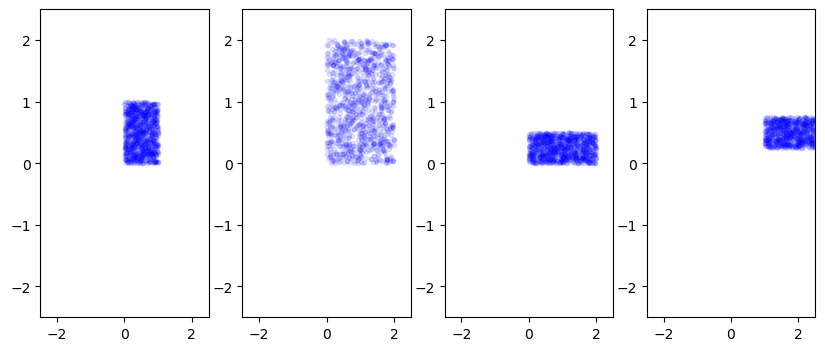

In [4]:
z = torch.rand(1000,2)
print(z.shape)
z2 = 2 * z
#z3 = torch.tensor(z[:,0]*2, z[:,1]*0.5)

plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
plt.plot(z[:,0], z[:,1], 'b.', alpha=0.1);
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.subplot(1, 4, 2)
plt.plot(z2[:,0], z2[:,1], 'b.', alpha=0.1);
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5);

plt.subplot(1, 4, 3)
plt.plot(z[:,0]*2, z[:,1]*0.5, 'b.', alpha=0.1);
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5);

z = z + 0.5
plt.subplot(1, 4, 4)
plt.plot(z[:,0]*2, z[:,1]*0.5, 'b.', alpha=0.1);
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5);

**(a) How does scaling affect the area of the square? And how does it affect the probability density inside the square? <span style="float:right"> (1 point)</span>**

TODO: your answer here

**(b) If we scale one dimension by a factor 2, and another by a factor 0.5, how does this affect the area and the probability density? <span style="float:right"> (1 point)</span>**

Area and density remain the same but shape is different, exand later!


The determinant of the Jacobian corresponds to the scale factor of the area. The log determinant of the Jacobian is of course the log of this scale factor.

**(c) Use this knowledge to implement an invertible function that scales the input by a scale factor for each dimension.<span style="float:right"> (1 point)</span>**

In [37]:
class Scale(FlowLayer):
    def __init__(self, scale):
        self.scale = scale

    def forward(self, z):
        
        scaled_z = self.scale*z
        log_det = torch.sum(torch.log(self.scale))


        return scaled_z, log_det

    def inverse(self, z):
        
        scaled_z = z/self.scale
        log_det = -torch.sum(torch.log(self.scale))

        return scaled_z, log_det

**(d) Test your implementation.<span style="float:right"> (no points)</span>**

In [6]:
layer = Scale(torch.tensor([2,2]))
test_flow_layer(layer, torch.randn(10,2))

**(e) If we translate the points by adding a constant, how does this affect the area and probability distribution? <span style="float:right"> (1 point)</span>**

The area and probability distribution should be unchanged, given that translating points by a constant would change only the mean. 


**(f) Use this knowledge to implement an invertible function that translates the input by a fixed offset.<span style="float:right"> (1 point)</span>**

In [38]:
class Translate(FlowLayer):
    def __init__(self, offset):
        self.offset = offset

    def forward(self, z):

        scaled_z = self.offset + z
        log_det = 0


        return scaled_z, log_det

    def inverse(self, z):
        
        scaled_z = z - self.offset
        log_det = 0

        return scaled_z, log_det

**(g) Test your implementation.<span style="float:right"> (no pointss)</span>**

In [8]:
layer = Translate(torch.tensor([2,2]))
test_flow_layer(layer, torch.randn(10,2))

## 10.2 Invertible transformations for RealNVP (10 points)

In this section we will build all the invertible transformations that we need to implement the RealNVP normalizing flow model.

### Affine coupling

The main ingredient of our normalizing flow model is going to be the *affine coupling layer*.
This layer takes an input that is split in two parts ($z_A$ and $z_B$), and applies an affine tranformation to $z_B$ using parameters that come from a neural network block applied on $z_A$.

In other words:
$$z_B' = \exp(s) z_B + t$$
where
$$s,t = f(z_A)$$

We will handle the splitting of a single tensor into two later. For this layer, the input and output will be a tuple of tensors.

**(a) Complete the implementation below.<span style="float:right"> (3 points)</span>**

Hint: To get two values from the neural network block $f(z_A)$ (`block` in the code below), you can use `torch.chunk`, which splits a single tensor along a given dimension into a tuple of tensors.

In [9]:
class AffineCoupling(FlowLayer):
    def __init__(self, block):
        super().__init__()
        self.block = block

    def forward(self, z):
        zA, zB = z
        result = self.block(zA)
        s, t = torch.chunk(result, 2, dim=1)
        zB = torch.exp(s) * zB + t
        log_det = s.sum(dim=1)
        return (zA, zB), log_det

    def inverse(self, z):
        zA, zB = z
        result = self.block(zA)
        s, t = torch.chunk(result, 2, dim=1)
        zB = (zB - t) * torch.exp(-s)
        log_det = -s.sum(dim=1)
        return (zA, zB), log_det

For the neural network blocks in the coupling layers, we will use simple MLPs with two hidden layers and ReLU activation functions.

**(b) Complete the implementation of `block` below.<span style="float:right"> (1 point)</span>**

Note: the output will be split into $s$ and $t$ by the AffineCoupling layer, both of which have `dim_B` columns.

In [10]:
def block(dim_A, dim_B, dim_hidden):
    """
    Create a neural network block for use in an `AffineCoupling` layer.
    Parameters:
      dim_A: the dimensionality of z_A
      dim_B: the dimensionality of z_B
      dim_hidden: the dimensionality of the hidden layers
    """
    return torch.nn.Sequential(
        torch.nn.Linear(dim_A, dim_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(dim_hidden, dim_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(dim_hidden, 2*dim_B)
    )

**(c) Use the code below to verify that your implementation is correct.<span style="float:right"> (no points)</span>**

In [11]:
# Verify the implementation of the AffineCoupling layer.
layer = AffineCoupling(block(5, 4, 12))
z = (torch.randn(3, 5), torch.randn(3, 4))
test_flow_layer(layer, z)
assert not isclose(layer.forward(z)[0], z), "The layer should not be trivial"

**(d) If we apply two AffineCoupling functions after eachother, does this give a more powerful or flexible function compared to a single AffineCoupling layer? Explain your answer.<span style="float:right"> (1 point)</span>**

TODO: your answer here

### Plumbing

Before we can actually use the affine coupling layer, we will need to do some plumbing.

The affine coupling layers we just defined above needs the input to be split into two parts (called $z_A$ and $z_B$ in the book). We can implement this splitting as a separate flow layer, because the splitting by itself is also an invertible transformation.

**(e) Complete the implementation of `Split` below.<span style="float:right"> (1 point)</span>**

To split a tensor you can use `torch.chunk`, which returns a tuple of tensors.
To combine tensors you can use `torch.cat`.

In [12]:
class Split(FlowLayer):
    def forward(self, z):
        split_z = torch.chunk(z, 2, dim=1)
        log_det = torch.zeros(num_samples(z))
        return split_z, log_det
    def inverse(self, z):
        merged_z = torch.cat(z, dim=1)
        log_det = torch.zeros(num_samples(merged_z))
        return merged_z, log_det

class Merge(FlowLayer):
    def forward(self, z):
        return Split().inverse(z)
    def inverse(self, z):
        return Split().forward(z)

assert isinstance(Split().forward(torch.randn(3, 9)), tuple), "Split should produce a tuple: split_z, log_det"
assert isinstance(Split().forward(torch.randn(3, 9))[0], tuple), "Split should produce a tuple"
assert isinstance(Split().inverse((torch.randn(3, 5), torch.randn(3, 4)))[0], torch.Tensor), "Split's inverse should produce a tensor"
test_flow_layer(Split(), torch.randn(3, 9))
test_flow_layer(Merge(), (torch.randn(3, 5), torch.randn(3, 4)))

The affine coupling layer always operates on the second part of the tuple, $z_B$.
A simple way to also change $z_A$ is to swap the elements in the tuple.

**(f) Implement a layer that swaps the two elements of a tuple.<span style="float:right"> (1 point)</span>**

In [13]:
class Swap(FlowLayer):
    def forward(self, z):
        z1, z2 = z
        return (z2, z1), torch.zeros(num_samples(z))
    def inverse(self, z):
        return self.forward(z)

z = (torch.randn(3, 5), torch.randn(3, 4))
test_flow_layer(Swap(), z)
z = (torch.randn(3, 5), torch.randn(3, 5))
assert not isclose(Swap().forward(z)[0], z), "The layer should not be trivial"

### Sequential composition

The composition of multiple invertible functions is still an invertible function.
Normaly when composing multiple layers in sequence you would use `torch.nn.Sequential`. But that does not work for our `FlowLayer`s. Instead we can make our own class for sequential composition.

**(g) Complete the implementation below.<span style="float:right"> (2 points)</span>**

In [14]:
class SequentialFlow(FlowLayer):
    def __init__(self, *layers):
        super().__init__()
        self.layers = torch.nn.ModuleList(layers)

    def forward(self, z):
        log_det = torch.zeros(num_samples(z))
        for layer in self.layers:
            z, ld = layer.forward(z)
            log_det += ld
        return z, log_det

    def inverse(self, z):
        log_det = torch.zeros(num_samples(z))
        for layer in reversed(self.layers):
            z, ld = layer.inverse(z)
            log_det += ld
        return z, log_det

**(h) Verify the implementation of `SequentialFlow`.<span style="float:right"> (1 point)</span>**

Make sure to use multiple non-trivial layers to ensure that the composition works correctly.

In [15]:
# Verify the implementation
dim_A, dim_B, dim_hidden = 2, 2, 4
layer = SequentialFlow(
    Split(),
    AffineCoupling(block(dim_A, dim_B, dim_hidden)),
    Swap(),
    AffineCoupling(block(dim_A, dim_B, dim_hidden)),
    Merge()
)

z = torch.randn(10, 4)
test_flow_layer(layer, z)

# DEBUGGING, remove before submission

In [16]:
def debug_flow(layer, z):
    """
    Takes a SequentialFlow layer and an input tensor z, and prints the shapes and contents 
    of z at each step of the flow, with small descriptions.
    """
    print("Initial Input:")
    print(f"Shape: {z.shape}\nContents:\n{z}\n")
    
    current_z = z
    for i, sublayer in enumerate(layer.layers):
        print(f"Step {i+1}: {type(sublayer).__name__}")
        
        if isinstance(current_z, tuple):
            print(f"Input: Tuple of shapes {[t.shape for t in current_z]}")
            for j, t in enumerate(current_z):
                print(f"  Tuple[{j}] contents:\n{t}\n")
        else:
            print(f"Input: Shape {current_z.shape}\nContents:\n{current_z}\n")
        
        # Forward pass through the current sublayer
        current_z, log_det = sublayer.forward(current_z)
        
        # Print the output
        if isinstance(current_z, tuple):
            print(f"Output: Tuple of shapes {[t.shape for t in current_z]}")
            for j, t in enumerate(current_z):
                print(f"  Tuple[{j}] contents:\n{t}\n")
        else:
            print(f"Output: Shape {current_z.shape}\nContents:\n{current_z}\n")
        
        print(f"Log Determinant: {log_det}\n")
    
    print("Final Output:")
    if isinstance(current_z, tuple):
        print(f"Output: Tuple of shapes {[t.shape for t in current_z]}")
        for j, t in enumerate(current_z):
            print(f"  Tuple[{j}] contents:\n{t}\n")
    else:
        print(f"Output: Shape {current_z.shape}\nContents:\n{current_z}\n")


In [17]:
debug_flow(layer, torch.randn(10, 4))

Initial Input:
Shape: torch.Size([10, 4])
Contents:
tensor([[ 1.2519,  1.5180, -0.5026, -0.1825],
        [ 0.3940, -0.4661,  0.0286,  2.3463],
        [-0.9479,  0.8128,  1.2183,  1.4983],
        [-0.8006, -2.6179, -0.1313, -0.4766],
        [ 1.0063,  1.6533,  1.4378, -0.7464],
        [-0.0929, -0.5811, -0.5725,  0.7839],
        [-1.4070,  2.3076,  1.4022,  1.2207],
        [-0.6625,  1.2797, -0.0805,  0.4336],
        [-2.6631, -0.0971,  0.5959,  0.6458],
        [ 1.0206,  2.3932, -1.3728, -1.2460]])

Step 1: Split
Input: Shape torch.Size([10, 4])
Contents:
tensor([[ 1.2519,  1.5180, -0.5026, -0.1825],
        [ 0.3940, -0.4661,  0.0286,  2.3463],
        [-0.9479,  0.8128,  1.2183,  1.4983],
        [-0.8006, -2.6179, -0.1313, -0.4766],
        [ 1.0063,  1.6533,  1.4378, -0.7464],
        [-0.0929, -0.5811, -0.5725,  0.7839],
        [-1.4070,  2.3076,  1.4022,  1.2207],
        [-0.6625,  1.2797, -0.0805,  0.4336],
        [-2.6631, -0.0971,  0.5959,  0.6458],
        [ 1.020

## 10.3 Distributions (3 points)

The other ingredient in a normalizing flow model is a base distribution.
To sample from a normalizing flow, draw $z \sim p_\text{base}$, and tranform it with an invertible $f_\text{flow}$.

Fortunately for us, common probability distributions are already implemented in `torch.distributions`.

Unfortunately, these are mostly univariate distributions. What we need are distributions over vectors.
For this we can use a simple adapter class.

**(a) Complete the code below.<span style="float:right"> (1 points)</span>**

In [ ]:
class Multivariate:
    def __init__(self, width, dist=Normal(0,1)):
        self.width = width
        self.dist = dist

    def sample(self, n=1):
        """Draw n samples from this distribution."""
        return self.dist.sample((n, self.width)) # Sample n samples from the distribution

    def log_prob(self, x):
        """Compute the log probability of each sample in x."""
        return self.dist.log_prob(x).sum(dim=1) # How likely is it to observe x

dist = Multivariate(2)
assert dist.sample(10).shape == torch.Size((10, 2))
assert dist.log_prob(torch.randn(10,2)).shape == torch.Size((10,))
assert dist.log_prob(torch.zeros(1,2))[0] == -torch.log(torch.tensor(2 * torch.pi))

**(b) Use the following code to plot the density and some samples from this distribution.<span style="float:right"> (no points)</span>**

In [44]:
def plot_log_prob(model, xmin=-2.5, xmax=2.5, steps=500, min_prob=-10, colorbar=True):
    with torch.no_grad():
        x0, x1 = torch.meshgrid(torch.linspace(xmin, xmax, steps=steps),
                                torch.linspace(xmin, xmax, steps=steps), indexing='ij')
        x = torch.stack([x0.flatten(), x1.flatten()], axis=1)
        y = model.log_prob(x).cpu().numpy()
        y = y.reshape(x0.shape)
        y[y < min_prob] = min_prob - 1
        plt.contourf(x0.cpu().numpy(), x1.cpu().numpy(), y)
        if colorbar:
            plt.colorbar()

def plot_samples(model, n = 10000, xmin=-2.5, xmax=2.5):
    with torch.no_grad():
        if isinstance(model, Distribution):
            samples = model.sample([n]).cpu()
        else:
            samples = model.sample(n).cpu()
        plt.plot(samples[:, 0], samples[:, 1], 'b.', alpha=0.1)
        plt.xlim(xmin, xmax)
        plt.ylim(xmin, xmax)

def plot_log_prob_and_samples(model, n = 10000, xmin=-2.5, xmax=2.5, steps=500, min_prob=-10):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plot_log_prob(model, xmin, xmax, steps, min_prob)
    plt.subplot(1, 2, 2)
    plot_samples(model, n, xmin, xmax)

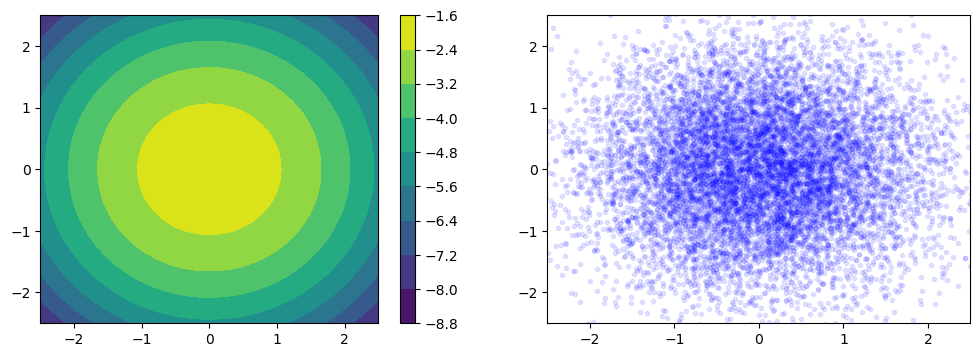

In [41]:
dist = Multivariate(2, Normal(0,1))
plot_log_prob_and_samples(dist)

### Normalizing flows as distributions

A normalizing flow model also gives a probability distribution.
So we can implement the same functions `sample` and `log_prob`.

To sample, take a sample from the base distribution and apply a transformation.

To compute the log probability, apply the inverse transformation, and compensate for the change in area.

**(c) Complete the code below.<span style="float:right"> (2 points)</span>**

In [42]:
class NormalizingFlow(torch.nn.Module):
    def __init__(self, base_distribution, *layers):
        super().__init__()
        self.base_distribution = base_distribution
        self.flow = SequentialFlow(*layers)

    def sample(self, n=1):
        """Draw n samples from this distribution."""
        z = self.base_distribution.sample(n)
        z, _ = self.flow.forward(z)
        return z

    def log_prob(self, x):
        """Compute the log probability of each sample in x."""
        z, log_det = self.flow.inverse(x)
        return self.base_distribution.log_prob(z) + log_det

**(d) As a simple test, we can visualize a normalizing flow with fixed layers.<span style="float:right"> (no points)</span>**

This distribution should be identical to a multivariate normal distribution.

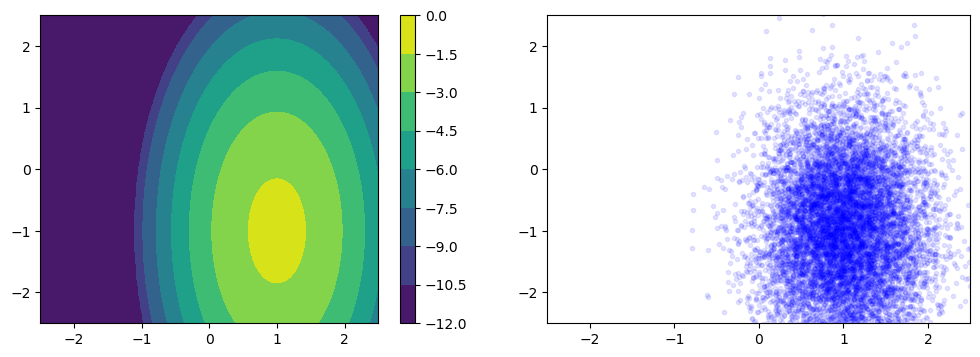

In [45]:
dist = NormalizingFlow(
    Multivariate(2, Normal(0,1)),
    Scale(torch.tensor([0.5,1])),
    Translate(torch.tensor([1,-1]))
)
plot_log_prob_and_samples(dist)

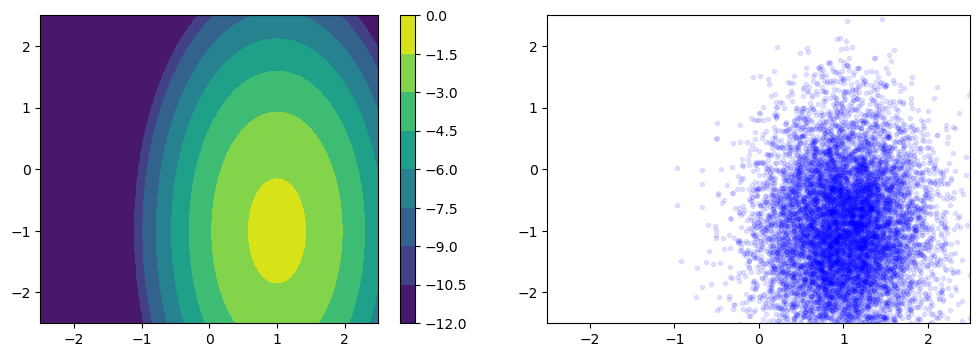

In [46]:
dist = MultivariateNormal(torch.tensor([1.0,-1.0]), torch.diag(torch.tensor([0.5,1.0]) ** 2))
plot_log_prob_and_samples(dist)

## 10.4 Training (2 points)

To train a normalizing flow model, we can maximize the log likelihood of the data, or equivalently minimize the negative log likelihood.

**(a) Implement the `train` function.<span style="float:right"> (2 points)</span>**

Assume that the data set contains `x,y` pairs, and ignore `y`.

In [ ]:
def train(model, data_loader, num_epochs=100, lr=0.001, optimizer=torch.optim.Adam, device=device):
    """
    Train a normalizing flow model on the given data set.
    """
    # TODO: Your code here.
    # Hint: See previous assignments

## 10.5 Two moons dataset (6 points)

In this assignment we will once again use the noisy two moons dataset.

In [ ]:
n_samples = 100000
noisy_moons = sklearn.datasets.make_moons(n_samples=n_samples, noise=.1)
noisy_moons[0][:, 0] -= np.mean(noisy_moons[0][:, 0])
noisy_moons[0][:, 0] /= np.std(noisy_moons[0][:, 0])
noisy_moons[0][:, 1] -= np.mean(noisy_moons[0][:, 1])
noisy_moons[0][:, 1] /= np.std(noisy_moons[0][:, 1])
plt.plot(noisy_moons[0][:, 0], noisy_moons[0][:, 1], '.', alpha=0.05);

In [ ]:
noisy_moons_points = torch.tensor(noisy_moons[0], dtype=torch.float32)
noisy_moons_labels = torch.tensor(noisy_moons[1])
moon_dataset = torch.utils.data.TensorDataset(noisy_moons_points, noisy_moons_labels)
moon_data_loader = torch.utils.data.DataLoader(moon_dataset, batch_size=128)

**(a) Create a normalizing flow model.<span style="float:right"> (1 point)</span>**

The model should have 4 affine coupling layers.
The neural network block should use a hidden dimension of 16.
Use a standard normal distribution as the base distribution.

In [ ]:
model = ... # TODO: Your code here.

**(b) Train the normalizing flow model.<span style="float:right"> (1 points)</span>**

Hint: the negative log probability per sample of the data after training should be < 1.9.

**(c) Plot the distribution of the trained model.<span style="float:right"> (no points)</span>**

In [ ]:
plot_log_prob_and_samples(model)

**(d) Plot the distribution of the trained model on top of the data.<span style="float:right"> (no points)</span>**

In [ ]:
plt.plot(noisy_moons[0][:, 0], noisy_moons[0][:, 1], 'r.', alpha=0.05)
plot_samples(model)

**(e) If you look closely, there is a region connecting the two moons that has a non-zero probability according to the model, which is not in the training data. Can you explain why this happens?<span style="float:right"> (1 point)</span>**

Note: Where these regions occur depends on the initialization of the model. These regions become smaller with more training.

TODO: your answer here

Instead of transforming points from the base distribution to the target distribution, we can use the inverse transformation of `model.flow` to tranform points back from the target distribution.

**(f) Transform the points in the dataset with this inverse tranformation, and plot them. <span style="float:right"> (1 point)</span>**

In [ ]:
def plot_inverse_samples(model, data):
    # TODO: implement

plot_inverse_samples(model, noisy_moons_points)

**(g) What distribution do you expect for the inversely transformed training data? And does the plot match your expectations? <span style="float:right"> (1 point)</span>**

TODO: your answer here

We can inspect what the different layers in the model are doing by making a copy of the trained model that skips some of the coupling layers.

In [ ]:
def part_model(model, num_coupling_layers):
    """Create a new model that uses only the first affine coupling layers."""
    layers = []
    for layer in model.flow.layers:
        if isinstance(layer, AffineCoupling):
            if num_coupling_layers > 0:
                num_coupling_layers -= 1
                layers.append(layer)
        else:
            layers.append(layer)
    return NormalizingFlow(model.base_distribution, *layers)

def plot_model_steps(model, steps):
    plt.figure(figsize=(3*steps, 3))
    for i in range(steps):
        plt.subplot(1, steps, i + 1)
        plot_log_prob(part_model(model,i), colorbar=False)

plot_model_steps(model, 5)

**(h) Train the model again, and compare the above plot between the two runs. Are the models similar?<span style="float:right"> (1 point)</span>**

In [ ]:
# model2 = ...

TODO: your answer here

## 10.6 Discussion (3 points)

**(a) How does the normalizing flow model differ from the GAN trained in assignment 9.7b?<span style="float:right"> (1 point)</span>**

Compare to both the generator and discriminator plots.

TODO: your answer here

**(b) We have used a standard normal distribution as the base distribution. Another choice is a uniform distribution. What is a potential problem with using a uniform distribution?<span style="float:right"> (1 point)</span>**

TODO: your answer here

**(c) According to the manifold hypothisis, real data often lies on a low dimensional manifold in a high dimensional space. Can you use this idea in a normalizing flow model, by having a low dimensional latent space? Explain your answer.<span class="float:right"> (1 point)</span>**

TODO: your answer here

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 29 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 36dc7f6 / 2024-11-21</span>